In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers



Using TensorFlow backend.


In [2]:

path = 'input/'
comp = 'jigsaw-toxic-comment-classification-challenge/'
EMBEDDING_FILE=f'{path}glove.6B.50d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'
TEST_DATA_FILE=f'{path}test.csv'

In [3]:


# configuring basic parameters

embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use


In [4]:

# Read in our data and replace missing values:

train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values



In [5]:
# Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed)

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))




In [6]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [7]:
# Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))




In [8]:
# Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
print("Mean",emb_mean,"StDiv",emb_std)




c:\users\rms170003\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


Mean 0.020940498 StDiv 0.6441043


In [9]:

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
final_embedding_matrix = np.zeros(((nb_words, embed_size+50)))
print("words not in glove")
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
    else:
        print(word)
    vec=np.zeros(50)
    word=word[:50]
    wc=0
    for c in word:
        vec[wc]=ord(c)/100.0
        wc+=1
    final_embedding_matrix[i]=np.concatenate((embedding_matrix[i],vec),axis=0)

words not in glove
don't
i'm
it's
i've
you're
doesn't
that's
can't
didn't
i'll
•
isn't
i'd
there's
wikipedia's
contribs
you've
won't
wasn't
he's
npov
wikiproject
haven't
article's
aren't
 
wouldn't
what's
shouldn't
tildes
let's
they're
you'll
wikipedian
we're
you'd
barnstar
''''''
couldn't
3rr
sockpuppet
dickhead
here's
helpme
f5fffa
arbcom
1px
fucksex
subject's
yourselfgo
userpage
people's
cocksucker
hasn't
—preceding
talkpage
buttsecks
mothjer
fggt
noobs
we'll
bastered
she's
weren't
'image'
philippineslong
oldid
sockpuppetry
we've
hanibal911you're
offfuck
who's
sexsex
deneid
‎
'''
user's
'fuck
pagedelete
notrhbysouthbanof
one's
mainpagebg
they've
adminship
don’t
cocksucking
diffs
checkuser
hadn't
criminalwar
bunksteve
sockpuppets
→
''''
marcolfuck
copyvio
boymamas
someone's
dropdown
ytmnd
administrators'
ffffff
world's
editor's
person's
edgar181
fack
tommy2010
contributors'
securityfuck
cuntbag
youbollocks
ain't
'the
concernthanks
ancestryfuck
userbox
it'll
delanoy
website's
wiki's
p

artlice
aulahehelalelalala
witzeman
shitting
japan's
geogre
•myears•mymouth
refrences
dicussion
wikinazi
mjpresson
desysop
5em
urself
pwned
propol
pacificwarrior101
1960's
“in
percieved
“blackpearl14
“svtcobra”
“whoville”
—talk
—gr
satusuro
encyclopedia's
bigissue
tusc
talkcontributions
fys
☯
'nuff
freplyspang
me'
reblock
sectioneer''
wikipedialies
werieth
25px
rangeblock
archieves
mauco
freestylefrappe
✽
articel
noah's
trácht
deleteing
becouse
'he
disce
discede
coord
fuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuckfuck
❤
editted
juicetalk
mwalla
 雲‍水
article'
otoh
''''let's
 farmbrough
harry's
banjeboi
editathon
stormie
book1a1contents
0422
blinguen
esoglou
cailil
sucksfrozen
'homosexuals'
f2p
chliorine
“we
nuetral
gurch
≈talk≈
fdffe7
oldlady
irishguy
andpieces
guettarda
innacurate
an3
nandesuka
isil
rawat's
vandelism
tast
statments
jeppiz
arsed
loadee
russavia

aym
tiamut
summerphd
tiptoety
retarted
world’s
'file'
―œ
chat • rff
korsentry


In [10]:
# Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size+50, weights=[final_embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
# Now we're ready to fit out model! Use validation_split when not submitting.

model.fit(X_t, y, batch_size=32, epochs=15, validation_split=0.3);


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 111699 samples, validate on 47872 samples
Epoch 1/15
111699/111699 [==============================] - 571s 5ms/step - loss: 0.0603 - acc: 0.9790 - val_loss: 0.0489 - val_acc: 0.9822
Epoch 2/15
111699/111699 [==============================] - 543s 5ms/step - loss: 0.0435 - acc: 0.9834 - val_loss: 0.0456 - val_acc: 0.9829
Epoch 3/15
111699/111699 [==============================] - 576s 5ms/step - loss: 0.0384 - acc: 0.9849 - val_loss: 0.0496 - val_acc: 0.9828
Epoch 4/15
111699/111699 [==============================] - 637s 6ms/step - loss: 0.0342 - acc: 0.9862 - val_loss: 0.0495 - val_acc: 0.9825
Epoch 5/15
111699/111699 [==============================] - 592s 5ms/step - loss: 0.0306 - acc: 0.9875 - val_loss: 0.0528 - val_acc: 0.9820
Epoch 6/15
111699/111699 [==============================] - 546s 5ms/step - loss: 0.0271 - acc: 0.9891 - val_loss: 0.0599 -

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total para

In [13]:
model.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [14]:
import matplotlib.pyplot as plt
A = range(1,len(model.history.history['acc'])+1)
B = [ round(i,5) for i in model.history.history['acc']]
C = [ round(i,5) for i in model.history.history['val_acc']]

plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# for xy in zip(A, B):                                       # <--
#     plt.annotate('TRN(%s, %s)' % xy, xy=xy, textcoords='data') # <--
# for xy in zip(A, C):                                       # <--
#     plt.annotate('TST(%s, %s)' % xy, xy=xy, textcoords='data') # <--

plt.legend(['train', 'test'], loc='upper left')
plt.show()

<Figure size 640x480 with 1 Axes>

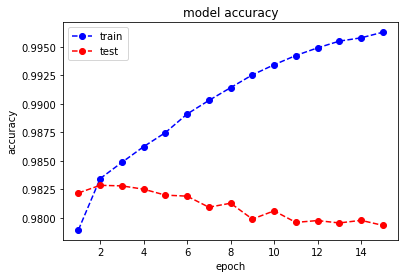

In [15]:
A = range(1,len(model.history.history['acc'])+1)
B = [ round(i,5) for i in model.history.history['acc']]
C = [ round(i,5) for i in model.history.history['val_acc']]
plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# for xy in zip(A, B):                                       # <--
#     plt.annotate('TRN(%s, %s)' % xy, xy=xy, textcoords='data') # <--
# for xy in zip(A, C):                                       # <--
#     plt.annotate('TST(%s, %s)' % xy, xy=xy, textcoords='data') # <--

plt.legend(['train', 'test'], loc='upper left')
plt.show()

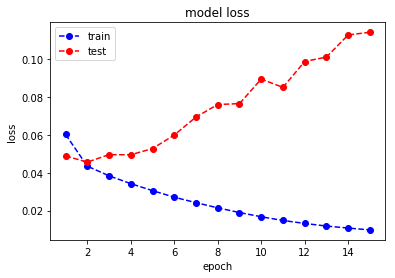

In [16]:
A = range(1,len(model.history.history['loss'])+1)
B = model.history.history['loss']
C = model.history.history['val_loss']
plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
def sample_test(S1,model):
    v=tokenizer.texts_to_sequences([S1])
    v=pad_sequences(v,maxlen=maxlen)
    y=list(model.predict([v], batch_size=1024, verbose=1))
    for i in range(6):
        print(y[0][i], list_classes[i])